Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("processed_data2.csv")

# Convert categorical data to numerical data using LabelEncoder
label_encoder = LabelEncoder()
df['City'] = label_encoder.fit_transform(df['City'])
df['Region'] = label_encoder.fit_transform(df['Region'])
df['Day_period'] = label_encoder.fit_transform(df['Day_period'])
df['Season'] = label_encoder.fit_transform(df['Season'])
df['Weekday_or_weekend'] = label_encoder.fit_transform(df['Weekday_or_weekend'])
df['Regular_day_or_holiday'] = label_encoder.fit_transform(df['Regular_day_or_holiday'])

# Define features and target including encoded columns
features = df[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene',
               'Region', 'Day_period', 'Month_encoded', 'Season', 'Weekday_or_weekend', 'Regular_day_or_holiday']]
target = df['AQI']

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


Applying PCA


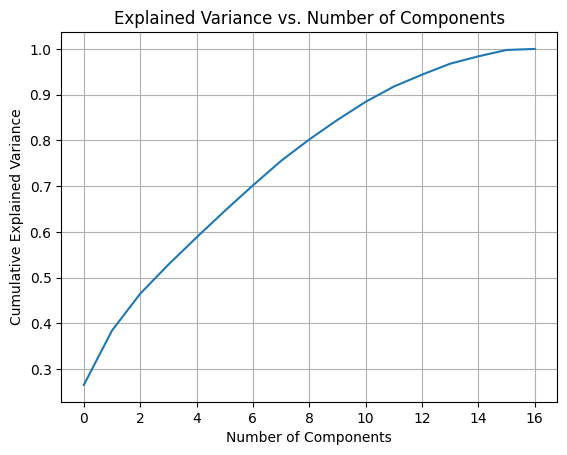

Number of components to retain 95% variance: 14


In [2]:
# Apply PCA
pca = PCA()
features_pca = pca.fit_transform(features_scaled)

# Plot the cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# Determine the number of components to retain
n_components = np.argmax(explained_variance >= 0.95) + 1  # Capturing 95% of variance
print(f"Number of components to retain 95% variance: {n_components}")

# Apply PCA with the optimal number of components
pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features_scaled)


Split data into training and test set


In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_pca, target, test_size=0.3, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2517657, 14)
X_test shape: (1078996, 14)
y_train shape: (2517657,)
y_test shape: (1078996,)


Define and compile ANN model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the ANN model
model = Sequential([
    Dense(64, input_dim=n_components, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')


c:\Users\geedh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Train the model


In [5]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Continue training the model for 8 more epochs
history_additional = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
78677/78677 ━━━━━━━━━━━━━━━━━━━━ 169s 2ms/step - loss: 0.1914 - val_loss: 0.1648
Epoch 2/10
78677/78677 ━━━━━━━━━━━━━━━━━━━━ 157s 2ms/step - loss: 0.1610 - val_loss: 0.1579
Epoch 3/10
78677/78677 ━━━━━━━━━━━━━━━━━━━━ 166s 2ms/step - loss: 0.1564 - val_loss: 0.1567
Epoch 4/10
78677/78677 ━━━━━━━━━━━━━━━━━━━━ 166s 2ms/step - loss: 0.1540 - val_loss: 0.1519
Epoch 5/10
78677/78677 ━━━━━━━━━━━━━━━━━━━━ 156s 2ms/step - loss: 0.1524 - val_loss: 0.1506
Epoch 6/10
78677/78677 ━━━━━━━━━━━━━━━━━━━━ 152s 2ms/step - loss: 0.1508 - val_loss: 0.1506
Epoch 7/10
78677/78677 ━━━━━━━━━━━━━━━━━━━━ 165s 2ms/step - loss: 0.1501 - val_loss: 0.1492
Epoch 8/10
78677/78677 ━━━━━━━━━━━━━━━━━━━━ 161s 2ms/step - loss: 0.1492 - val_loss: 0.1484
Epoch 9/10
78677/78677 ━━━━━━━━━━━━━━━━━━━━ 197s 2ms/step - loss: 0.1484 - val_loss: 0.1496
Epoch 10/10
78677/78677 ━━━━━━━━━━━━━━━━━━━━ 161s 2ms/step - loss: 0.1477 - val_loss: 0.1491
Epoch 1/8
78677/78677 ━━━━━━━━━━━━━━━━━━━━ 155s 2ms/step - loss: 0.1473 - val_l

evaluate the model


In [6]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train)
val_loss = model.evaluate(X_test, y_test)
print("Training loss (MSE):", train_loss)
print("Validation loss (MSE):", val_loss)


78677/78677 ━━━━━━━━━━━━━━━━━━━━ 81s 1ms/step - loss: 0.1462
33719/33719 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step - loss: 0.1462
Training loss (MSE): 0.1458999514579773
Validation loss (MSE): 0.14660662412643433


make predictions and calculate metrics


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate additional evaluation metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

val_mae = mean_absolute_error(y_test, y_test_pred)
val_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
val_r2 = r2_score(y_test, y_test_pred)

print("Training MAE:", train_mae)
print("Training RMSE:", train_rmse)
print("Training R^2:", train_r2)

print("Validation MAE:", val_mae)
print("Validation RMSE:", val_rmse)
print("Validation R^2:", val_r2)


78677/78677 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step
33719/33719 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step
Training MAE: 0.2698263837475009
Training RMSE: 0.3819674483622832
Training R^2: 0.8542152494740642
Validation MAE: 0.27037237031198236
Validation RMSE: 0.38289338240321924
Validation R^2: 0.8531237023836009


plot learning curves and actual vs predicted values

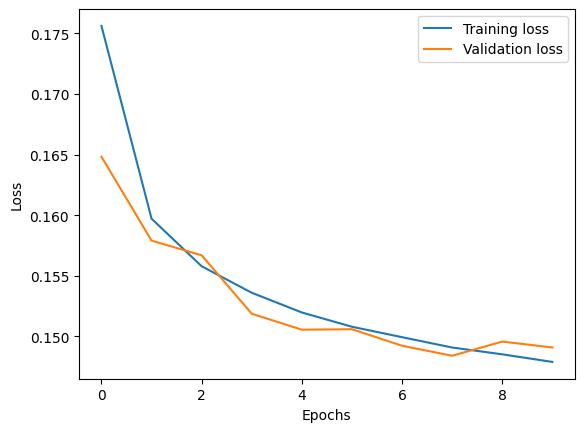

MAPE: 1.15


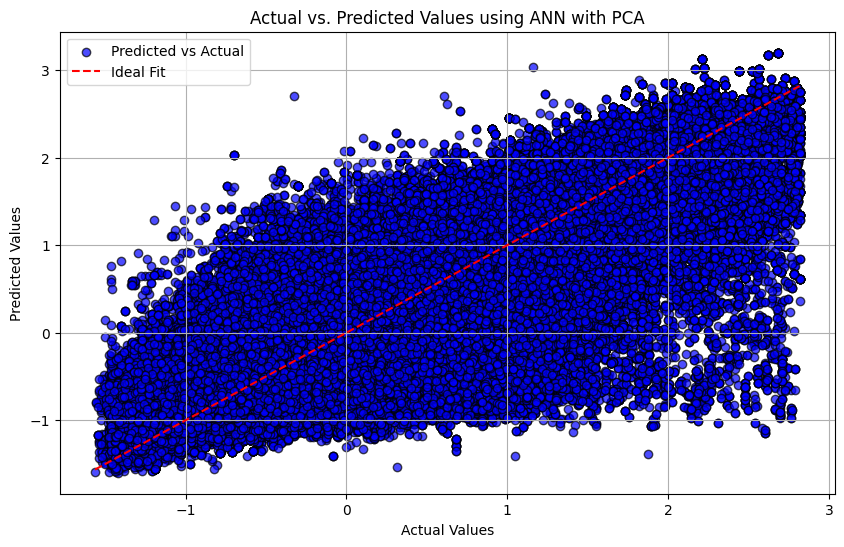

In [8]:
# Plot learning curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate MAPE
val_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f"MAPE: {val_mape:.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', edgecolor='k', alpha=0.7, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values using ANN with PCA')
plt.legend()
plt.grid(True)
plt.show()


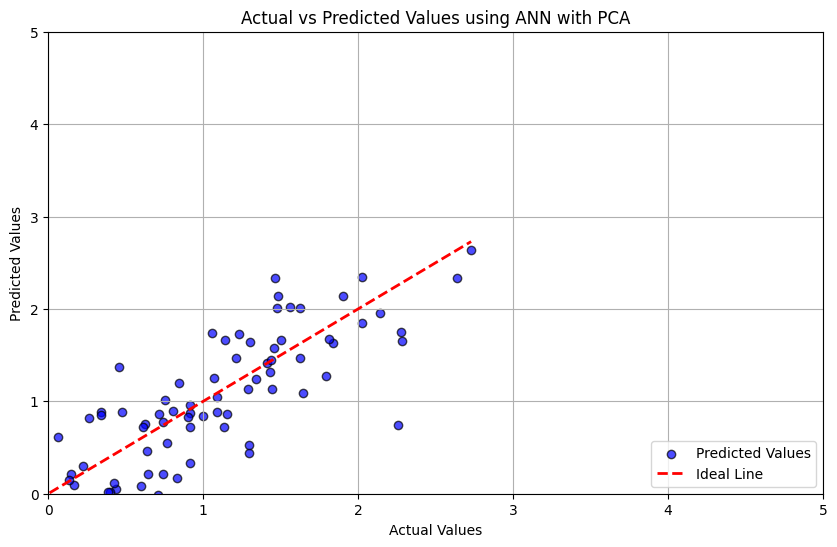

In [14]:
# Create a dictionary with the metrics
metrics = {
    'R²': val_r2,
    'MAPE': val_mape,
    'MAE': val_mae,
    'RMSE': val_rmse
}
num_points = 200  # Adjust this number to display more or fewer points

# Select a subset of the data
y_test_subset = y_test[:num_points]
y_pred_subset = y_test_pred[:num_points]

plt.figure(figsize=(10, 6))

# Plot actual vs predicted values for the subset
plt.scatter(y_test_subset, y_pred_subset, color='blue', edgecolor='k', alpha=0.7, label='Predicted Values')

# Ideal line
plt.plot([y_test_subset.min(), y_test_subset.max()], [y_test_subset.min(), y_test_subset.max()], 'r--', lw=2, label='Ideal Line')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values using ANN with PCA')

# Set the x and y axis scales to 0-20
plt.xlim([0, 5])
plt.ylim([0, 5])

# Add a legend
plt.legend(loc='lower right')

# Add a grid
plt.grid(True)

plt.show()